# Training a neural network model to generate a document deformation mesh in an image.

Author: Maciej Kubiś

Date: 2025-03-24

The notebook will allow training of various AI models created using **PyTorch**. Various architectures modeled on **U-Net** will be tested.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib.util
import sys

sys.path.append("../src") 

spec = importlib.util.spec_from_file_location("data_generator", "../src/data_generator.py")
data_generator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(data_generator)

spec = importlib.util.spec_from_file_location("neuralnet_handler", "../src/neuralnet_handler.py")
neuralnet_handler = importlib.util.module_from_spec(spec)
spec.loader.exec_module(neuralnet_handler)

## Configuration

It is possible to set device where will be handle neural network. Image generator require file with any text to produce random content of documents.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = data_generator.DocumentImageGenerator("../src/assets/text.txt")

nn_handler = neuralnet_handler.NeuralNetHandler(None, generator, device, 2, 0.001, 2)

Using device: cpu
Model is None. Please provide a valid model using set_model() method.


## U-Net with batch normalization

In [3]:
class UNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super(UNet, self).__init__()
        # Encoder part
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU(inplace=True)
        )
        
        # Decoder part
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim*4, hidden_dim*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            
            nn.Conv2d(hidden_dim*2, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            
            nn.Conv2d(hidden_dim, 2, kernel_size=3, padding=1),
        )
        
    def forward(self, x):
        # Get input dimensions
        batch_size, channels, height, width = x.shape
        
        # Pass through encoder
        features = self.encoder(x)
        
        # Pass through decoder
        offsets = self.decoder(features)
        
        # Resize to input dimensions if necessary
        if offsets.shape[2:] != (height, width):
            offsets = nn.functional.interpolate(offsets, size=(height, width), mode='bilinear', align_corners=True)
        
        return offsets
    
model = UNet()

nn_handler.set_model(model, "unet") 

#### Function for plotting results:

In [4]:
def plot():
    # Clear the output before plotting
    from IPython.display import clear_output
    clear_output(wait=True)

    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.plot(nn_handler.get_train_losses(), label='Training Loss')
    plt.plot(nn_handler.get_val_losses(), label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss U-Net PyTorch')
    plt.legend()
    plt.show()

### Training and results

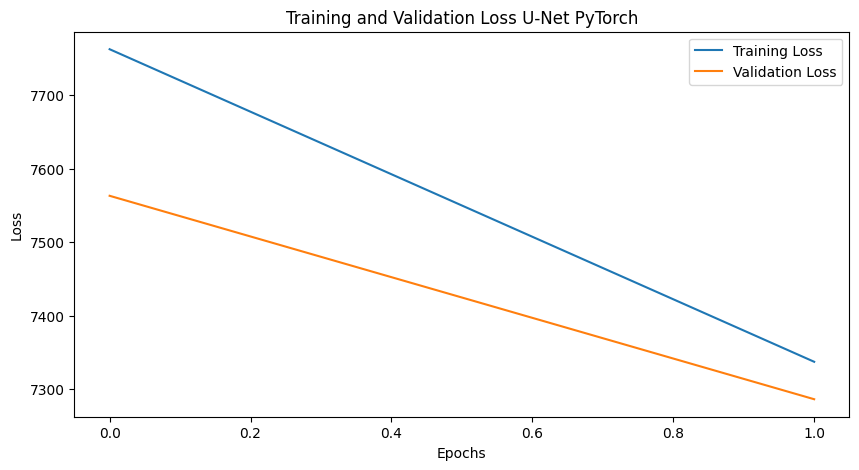

In [5]:
nn_handler.train()

plot()

#### Ensure model save

In [6]:
nn_handler.save_model("../models/unet.pth")

Model saved to ../models/unet.pth


## U-Net with skip connections

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetWithSkip(nn.Module):
    def __init__(self, hidden_dim=64):
        super(UNetWithSkip, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU(inplace=True),
        )
        
        # Decoder
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = nn.Sequential(
            nn.Conv2d(hidden_dim*4 + hidden_dim*2, hidden_dim*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(inplace=True),
        )
        
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = nn.Sequential(
            nn.Conv2d(hidden_dim*2 + hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        
        self.final_conv = nn.Conv2d(hidden_dim, 2, kernel_size=3, padding=1)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        
        # Encoder path
        x1 = self.enc1(x)       # shape: (B, hidden_dim, H, W)
        x2 = self.enc2(self.pool1(x1))  # (B, hidden_dim*2, H/2, W/2)
        x3 = self.bottleneck(self.pool2(x2))  # (B, hidden_dim*4, H/4, W/4)

        # Decoder path
        x = self.up1(x3)
        if x.shape[2:] != x2.shape[2:]:
            x2 = F.interpolate(x2, size=x.shape[2:], mode='bilinear', align_corners=True)
        x = self.dec1(torch.cat([x, x2], dim=1))  # concat skip connection

        x = self.up2(x)
        if x.shape[2:] != x1.shape[2:]:
            x1 = F.interpolate(x1, size=x.shape[2:], mode='bilinear', align_corners=True)
        x = self.dec2(torch.cat([x, x1], dim=1))  # concat skip connection
        
        offsets = self.final_conv(x)

        # Resize if needed
        if offsets.shape[2:] != (height, width):
            offsets = F.interpolate(offsets, size=(height, width), mode='bilinear', align_corners=True)

        return offsets

model = UNetWithSkip()

nn_handler.set_model(model, "unet_with_skip") 

### Training and results

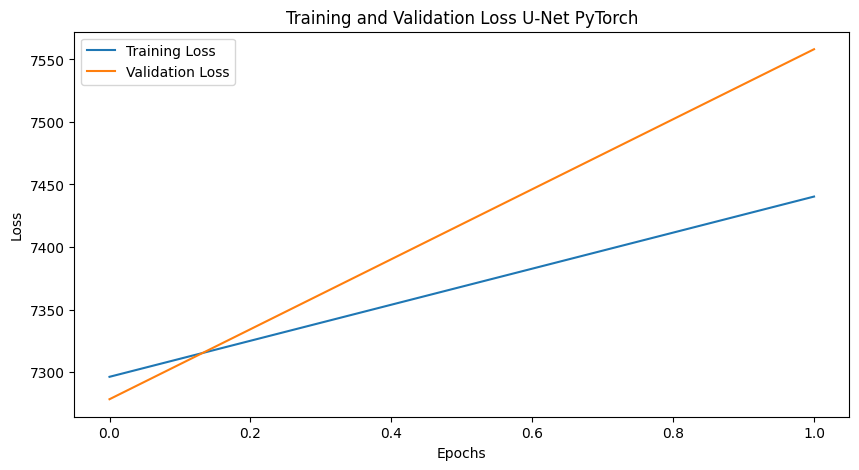

In [8]:
nn_handler.train()

plot()

#### Ensure model save

In [ ]:
nn_handler.save_model("../models/unet_with_skip.pth")

Model saved to ../models/unet_with_skips.pth


## Simple U-Net

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleUNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super(SimpleUNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        # Decoder
        self.dec1 = nn.Sequential(
            nn.Conv2d(hidden_dim * 2, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(hidden_dim, 2, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        h, w = x.shape[2], x.shape[3]

        # Encoder
        x = self.enc1(x)
        x = self.enc2(x)

        # Decoder
        x = self.dec1(x)
        x = self.dec2(x)

        # Final size correction
        if x.shape[2:] != (h, w):
            x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)

        return x
    
model = SimpleUNet()

nn_handler.set_model(model, "simple_unet") 

### Training and results

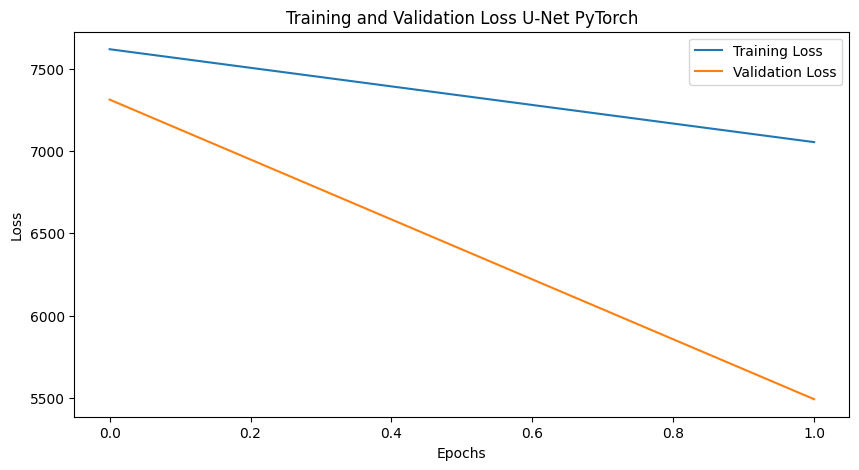

In [11]:
nn_handler.train()

plot()

#### Ensure model save

In [12]:
nn_handler.save_model("../models/simple_unet.pth")

Model saved to ../models/simple_unet.pth
